In [128]:
import torch
from torch import nn
from torch import optim
from torchmetrics import Accuracy
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

### Make classification data and get it ready

In [32]:
numSamples = 1000

X, y = make_circles(n_samples=numSamples, noise=0.03, random_state=42)

In [33]:
print(f'First five X features:\n{X[:5]}')
print(f'First 5 y labels:\n{y[:5]}')

First five X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels:
[1 1 1 1 0]


In [34]:
# Make dataframe of circle data
circles = pd.DataFrame(data={
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [35]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

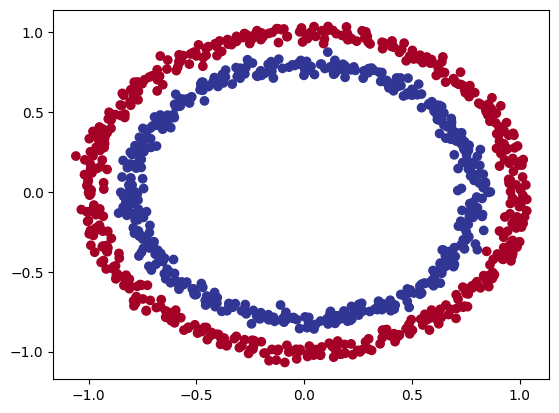

In [36]:
# Visualize with a plot
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

#### Input and Output shapes

In [37]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [38]:
# View first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shape of one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape of one sample of X: (2,) and the same for y: ()


#### Turn data into tensors and create train-test split

In [39]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View first five sample
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

### Building a model

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [61]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [62]:
model_0 = CircleModelV0()
model_0.to(device)
model_0

CircleModelV0(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [63]:
# Make untrained predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(y_test)}, Shape: {y_test.shape}')
print(f'First 10 predictions:\n{untrained_preds[:10]}')
print(f'First 10 test labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])
First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)
First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### Setup loss function and optimizer

BCEWithLogitsLoss is same as BCELoss except it adds a Sigmoid layer before computing loss

In [64]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)

In [65]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100.0
    return acc

### Train model

#### Going from raw model outputs to predicted labels

In [66]:
# View forward pass of first 5 outputs
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [67]:
y_pred_probs = torch.sigmoid(y_logits) # These are prediction probabilities
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], grad_fn=<SigmoidBackward0>)

In [68]:
# Find predicted labels
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [69]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#### Building a training and testing loop

In [70]:
torch.manual_seed(42)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    if epoch%10 == 0:
        print(f'Epoch: {epoch+1} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')


Epoch: 1 | Train Loss: 0.69569, Train Accuracy: 50.00%, Test Loss: 0.69721, Test Accuracy: 50.00%
Epoch: 11 | Train Loss: 0.69403, Train Accuracy: 50.00%, Test Loss: 0.69615, Test Accuracy: 50.00%
Epoch: 21 | Train Loss: 0.69343, Train Accuracy: 46.00%, Test Loss: 0.69585, Test Accuracy: 48.50%
Epoch: 31 | Train Loss: 0.69321, Train Accuracy: 49.00%, Test Loss: 0.69577, Test Accuracy: 47.50%
Epoch: 41 | Train Loss: 0.69312, Train Accuracy: 49.50%, Test Loss: 0.69573, Test Accuracy: 46.50%
Epoch: 51 | Train Loss: 0.69308, Train Accuracy: 50.38%, Test Loss: 0.69569, Test Accuracy: 46.50%
Epoch: 61 | Train Loss: 0.69306, Train Accuracy: 50.50%, Test Loss: 0.69564, Test Accuracy: 46.50%
Epoch: 71 | Train Loss: 0.69305, Train Accuracy: 50.50%, Test Loss: 0.69559, Test Accuracy: 46.50%
Epoch: 81 | Train Loss: 0.69304, Train Accuracy: 50.75%, Test Loss: 0.69553, Test Accuracy: 46.50%
Epoch: 91 | Train Loss: 0.69303, Train Accuracy: 50.38%, Test Loss: 0.69547, Test Accuracy: 46.50%


In [71]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary 

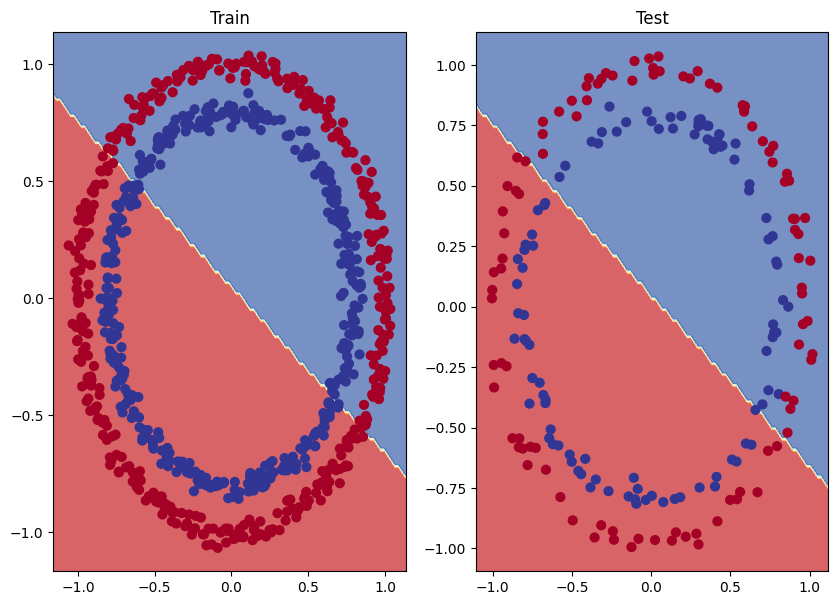

In [72]:
# Plot decision boundary for train and test sets
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

The problem here is that we're using Linear layers to classify where our data is non-linear which is why it is splitting predictions in a straight line to give 50% accuracy

### Improving the model

In [77]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 1)
    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [78]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_1.parameters(), lr = 0.1)

In [79]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch+1} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')


Epoch: 1 | Train Loss: 0.69396, Train Accuracy: 50.88%, Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 101 | Train Loss: 0.69305, Train Accuracy: 50.38%, Test Loss: 0.69379, Test Accuracy: 48.00%
Epoch: 201 | Train Loss: 0.69299, Train Accuracy: 51.12%, Test Loss: 0.69437, Test Accuracy: 46.00%
Epoch: 301 | Train Loss: 0.69298, Train Accuracy: 51.62%, Test Loss: 0.69458, Test Accuracy: 45.00%
Epoch: 401 | Train Loss: 0.69298, Train Accuracy: 51.12%, Test Loss: 0.69465, Test Accuracy: 46.00%
Epoch: 501 | Train Loss: 0.69298, Train Accuracy: 51.00%, Test Loss: 0.69467, Test Accuracy: 46.00%
Epoch: 601 | Train Loss: 0.69298, Train Accuracy: 51.00%, Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 701 | Train Loss: 0.69298, Train Accuracy: 51.00%, Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 801 | Train Loss: 0.69298, Train Accuracy: 51.00%, Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 901 | Train Loss: 0.69298, Train Accuracy: 51.00%, Test Loss: 0.69468, Test Accuracy: 46.00%


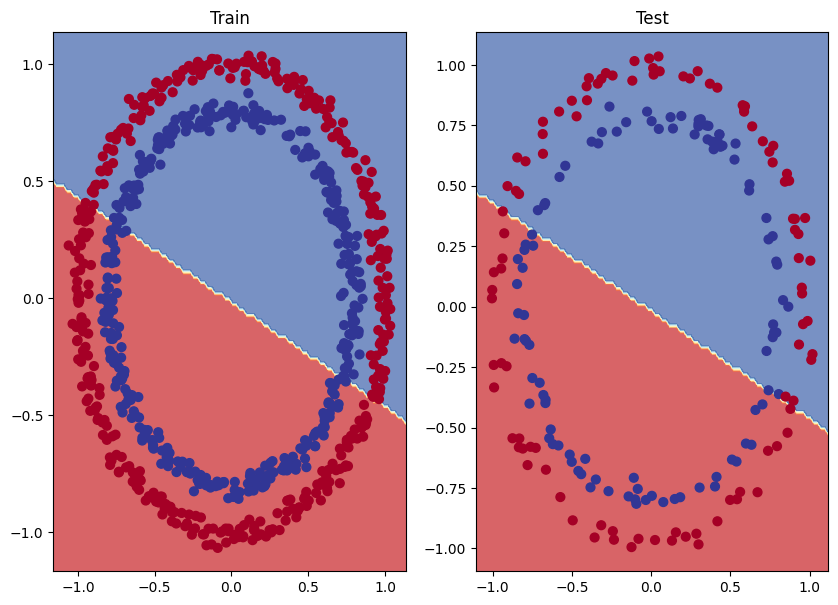

In [80]:
# Plot decision boundary for train and test sets
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### Missing piece: Non-linearity

#### Recreating non-linear data (red and blue circles)

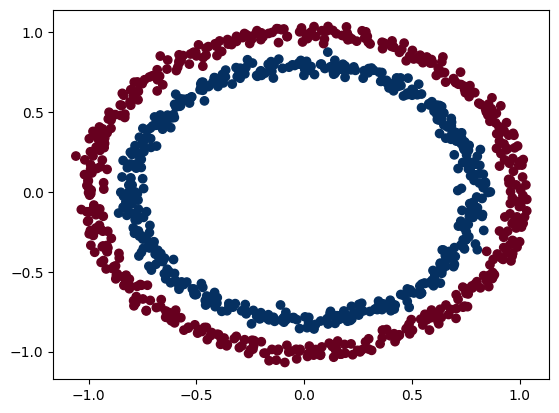

In [82]:
# Make and plot data
n_samples = 1000
X, y = make_circles(n_samples=n_samples, random_state=42, noise=0.03)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [83]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#### Building model with non-linearity

In [88]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(2, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
    
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [89]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model_2.parameters(), lr=0.1)

#### Training model with non-linearity

In [90]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Trainig
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch+1} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')


Epoch: 1 | Train Loss: 0.69295, Train Accuracy: 50.00%, Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 101 | Train Loss: 0.69115, Train Accuracy: 52.88%, Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 201 | Train Loss: 0.68977, Train Accuracy: 53.37%, Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 301 | Train Loss: 0.68795, Train Accuracy: 53.00%, Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 401 | Train Loss: 0.68517, Train Accuracy: 52.75%, Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 501 | Train Loss: 0.68102, Train Accuracy: 52.75%, Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 601 | Train Loss: 0.67515, Train Accuracy: 54.50%, Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 701 | Train Loss: 0.66659, Train Accuracy: 58.38%, Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 801 | Train Loss: 0.65160, Train Accuracy: 64.00%, Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 901 | Train Loss: 0.62362, Train Accuracy: 74.00%, Test Loss: 0.62145, Test Accuracy: 79.00%


#### Evaluating a model trained with non-linear activation functions

In [91]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test).squeeze()))
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

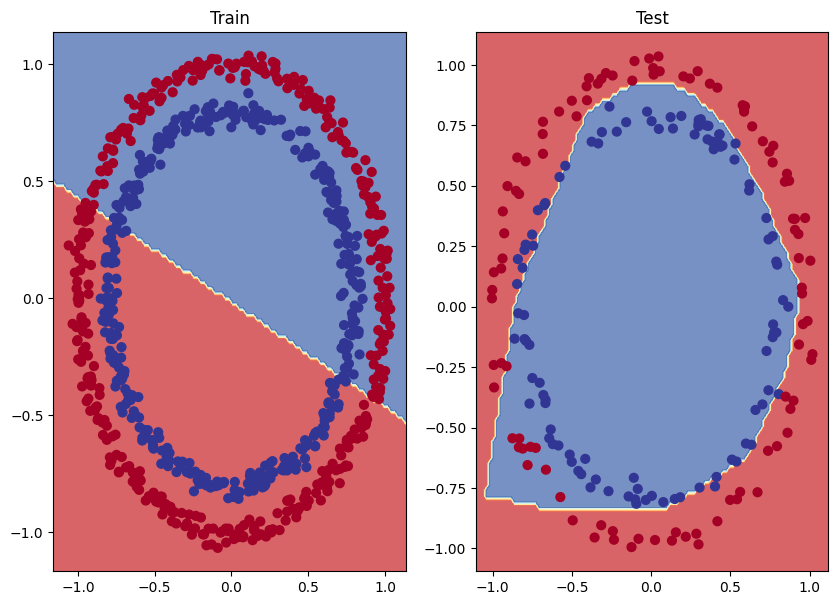

In [93]:
# Plot decision boundary
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

### Replicating non-linear activation functions

In [94]:
# Create toy data
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

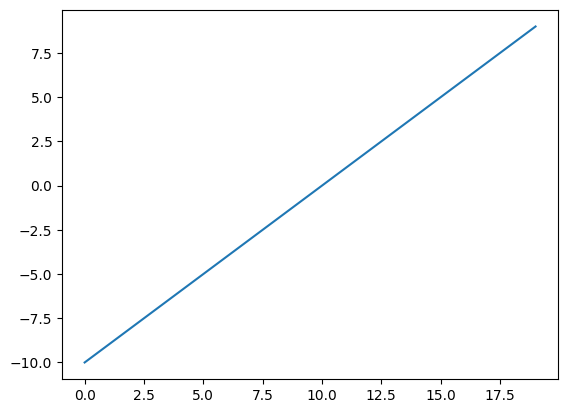

In [95]:
# Visualize it
plt.plot(A)

In [96]:
# Create ReLU function by hand
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

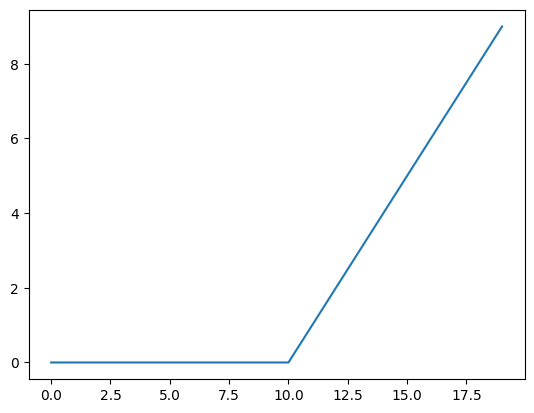

In [97]:
# Plot ReLU activated toy tensor
plt.plot(relu(A))

In [98]:
# Create custom sigmoid function
def sigmoid(x):
    return 1/(1+torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

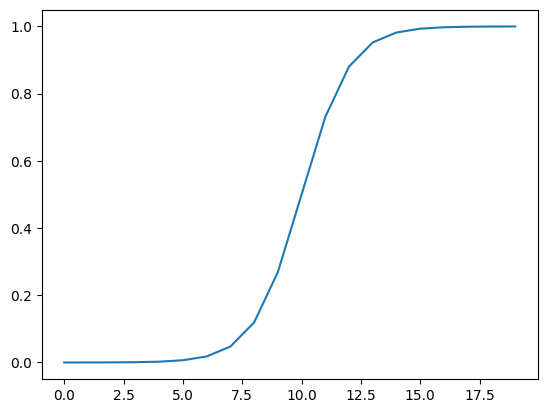

In [99]:
plt.plot(sigmoid(A))

### Putting together: Multi-class PyTorch model

#### Creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


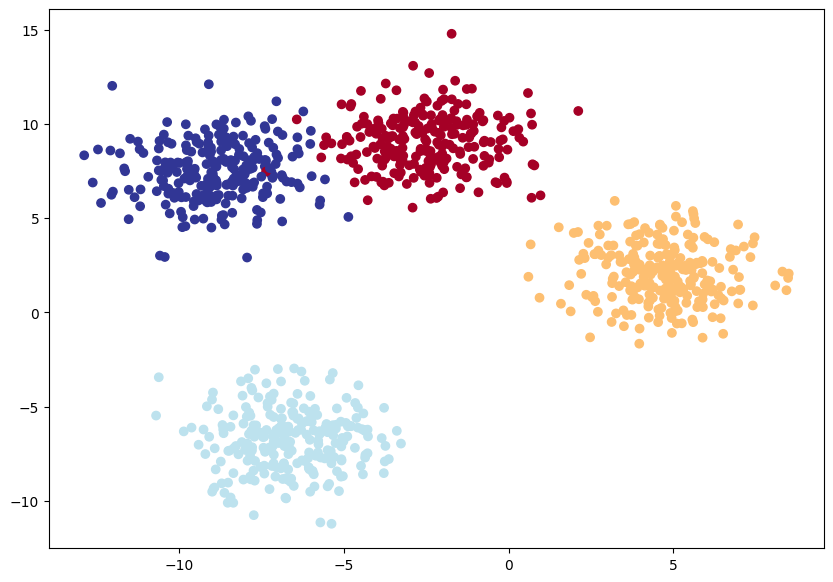

In [109]:
num_classes = 4
num_features = 2
random_seed = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=num_features, centers=num_classes, cluster_std=1.5, random_state=random_seed)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=random_seed)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu)

#### Building a multi-class classification model in PyTorch

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [111]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_3 = BlobModel(input_features=num_features,
                    output_features=num_classes).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### Creating loss function for multi-class Pytorch model

In [112]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_3.parameters(), lr = 0.1)

#### Getting prediction probabilities for multi-class PyTorch model

In [118]:
model_3(X_blob_train.to(device))[:5]

tensor([[ 0.8696, -0.7083, -0.3200,  0.5513],
        [-0.1989, -2.0320,  0.4267, -1.2864],
        [-0.9819, -0.0741,  1.0288, -1.7247],
        [-0.6449, -0.4877,  0.7777, -1.4029],
        [-0.2937, -1.7872,  0.4998, -1.3371]], grad_fn=<SliceBackward0>)

In [119]:
model_3(X_blob_train.to(device))[0].shape, num_classes

(torch.Size([4]), 4)

In [120]:
y_logits = model_3(X_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.1265, -0.7489,  0.2158, -0.4537],
        [ 0.1799, -0.7572,  0.1771, -0.3849],
        [ 0.0830, -0.6444,  0.2492, -0.4795],
        [ 0.1384, -0.7788,  0.2066, -0.4471],
        [ 0.2362, -0.5132,  0.1410, -0.2341]], grad_fn=<SliceBackward0>)
tensor([[0.3257, 0.1357, 0.3562, 0.1823],
        [0.3381, 0.1325, 0.3372, 0.1922],
        [0.3092, 0.1494, 0.3652, 0.1762],
        [0.3304, 0.1320, 0.3537, 0.1839],
        [0.3326, 0.1572, 0.3024, 0.2078]], grad_fn=<SliceBackward0>)


In [121]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3257, 0.1357, 0.3562, 0.1823], grad_fn=<SelectBackward0>)
tensor(2)


#### Creating train and test loop for multi-class classification PyTorch model

In [122]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # Training
    model_3.train()
    y_logits = model_3(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_blob_test)
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch%10 == 0:
        print(f'Epoch: {epoch+1} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')

Epoch: 1 | Train Loss: 1.92116, Train Accuracy: 26.00%, Test Loss: 0.85459, Test Accuracy: 55.00%
Epoch: 11 | Train Loss: 0.28521, Train Accuracy: 97.12%, Test Loss: 0.23787, Test Accuracy: 98.00%
Epoch: 21 | Train Loss: 0.11618, Train Accuracy: 99.00%, Test Loss: 0.10434, Test Accuracy: 98.50%
Epoch: 31 | Train Loss: 0.07650, Train Accuracy: 99.00%, Test Loss: 0.06791, Test Accuracy: 98.50%
Epoch: 41 | Train Loss: 0.06006, Train Accuracy: 99.00%, Test Loss: 0.05209, Test Accuracy: 99.00%
Epoch: 51 | Train Loss: 0.05133, Train Accuracy: 99.00%, Test Loss: 0.04346, Test Accuracy: 99.00%
Epoch: 61 | Train Loss: 0.04599, Train Accuracy: 99.00%, Test Loss: 0.03807, Test Accuracy: 99.50%
Epoch: 71 | Train Loss: 0.04242, Train Accuracy: 99.00%, Test Loss: 0.03440, Test Accuracy: 99.50%
Epoch: 81 | Train Loss: 0.03989, Train Accuracy: 99.00%, Test Loss: 0.03174, Test Accuracy: 99.50%
Epoch: 91 | Train Loss: 0.03800, Train Accuracy: 99.00%, Test Loss: 0.02972, Test Accuracy: 99.50%


#### Making and evaluating predictions

In [123]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test)
y_logits[:10]

tensor([[  9.0456,  15.0193,  -8.9350,  -4.0027],
        [ -0.7123, -18.4017,  -2.2680,   4.8906],
        [-13.7129, -24.1734,  13.9078,   5.7032],
        [  4.8120,   9.9222,  -4.2728,  -2.8219],
        [ 10.0808,   5.7406, -12.0556,  -1.2943],
        [ -1.4195, -22.5796,  -2.1152,   6.0351],
        [-12.6774, -19.5705,  13.3991,   4.4586],
        [  7.0078,  -0.7074,  -9.1888,   0.3454],
        [-16.1919, -32.0740,  15.7126,   7.7945],
        [  7.9838,   1.6031, -10.0499,  -0.2502]])

In [124]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_preds = y_pred_probs.argmax(dim = 1)
print(f'Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}')
print(f'Test accuracy: {accuracy_fn(y_blob_test, y_preds)}%')

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


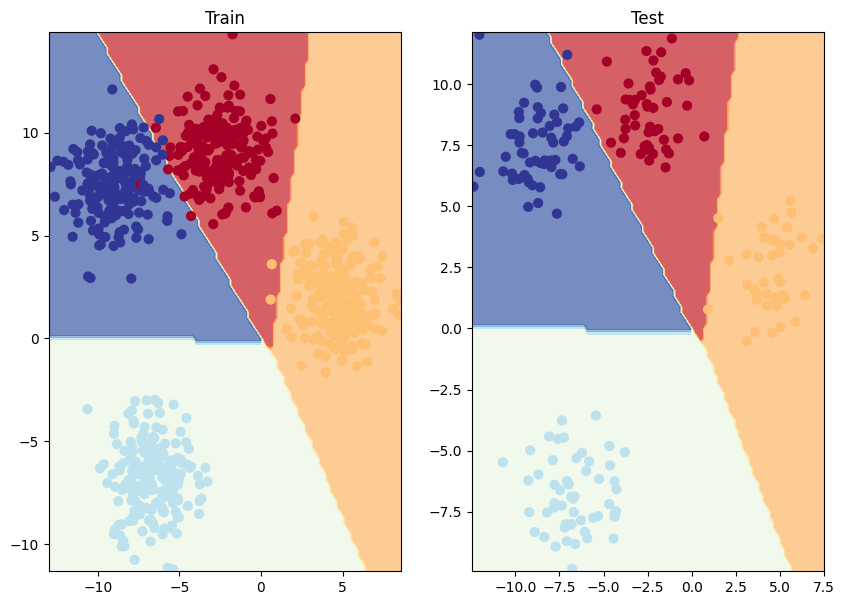

In [125]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

### More classification evaluation metrics

In [129]:
torchmetrics_accuracy = Accuracy(task = 'multiclass', num_classes = 4).to(device)
torchmetrics_accuracy(y_preds,y_blob_test)

tensor(0.9950)